In [1]:
import copy

import pandas as pd
import numpy as np
import optuna
import xgboost
import imblearn.over_sampling
import sklearn.model_selection
import dscribe.descriptors
import tqdm
import sklearn.pipeline

import functools

import matplotlib.pyplot as plt
import sklearn.impute
import seaborn as sns

import sys
sys.path.append("../../../")
import DigitalEcosystem.utils.figures

tqdm.tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 1234
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Load up the data
data_path = "../../refined/httpot/full_featurized_data.pkl"
data = pd.read_pickle(data_path).fillna(0)

In [4]:
noble_gases = ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Rn']
fblock = ['La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
          'Ac', 'Th', 'Pa', 'U',  'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']
d_synths = ['Rf', 'Db', 'Sg', 'Bh', 'HS', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']

bad_elements = noble_gases + fblock + d_synths

element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

decomp_mask = data['decomposition_energy (eV/atom)'] < 0.5

reasonable = data[element_mask & decomp_mask]

In [5]:
cols_to_drop = ['formula',
                'discovery_process (unitless)',
                'potcars (unitless)',
                'is_hubbard (unitless)',
                'energy_per_atom (eV)',
                'bandgap (eV)',
                'is_bandgap_direct (unitless)',
                'is_metal (unitless)',
                'energy_vdw_per_atom (eV/atom)',
                'total_magnetization (Bohr Magneton)']
target_column = ['exfoliation_energy_per_atom (eV/atom)']
matpedia_id = ['2dm_id (unitless)']
atoms_col = ['atoms_object (unitless)']

In [6]:
reasonable = reasonable[reasonable['exfoliation_energy_per_atom (eV/atom)'] > 0]

In [33]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]
matminer_descriptors = [
    'bond_length_average',
    'bond_angle_average',
    'average_cn',
    'global_instability',
    'perimeter_area_ratio',
    'ewald_energy_per_atom',
    'structural complexity per atom',
    'structural complexity per cell',
    'n_symmetry_ops'
]
xenonpy_matminer_descriptors = xenonpy_descriptors + matminer_descriptors

In [34]:
graph_descriptors = list(filter(lambda colname: any(i in colname for i in ["(bonds)", "(angles)", "(atoms)"]), reasonable.columns))

In [35]:
train, test = sklearn.model_selection.train_test_split(reasonable, test_size=0.1, random_state=RANDOM_SEED)

In [48]:
train_x_reg = np.nan_to_num(train[xenonpy_matminer_descriptors].to_numpy())
train_y_reg = np.nan_to_num(train[target_column].to_numpy())

test_x_reg = np.nan_to_num(test[xenonpy_matminer_descriptors].to_numpy())
test_y_reg = np.nan_to_num(test[target_column].to_numpy())

In [85]:
import sklearn.linear_model

current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x_reg), train_y_reg, test_size=0.1, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg

    params = {

    }

    current_reg = sklearn.pipeline.Pipeline([
        ("Scaler", sklearn.preprocessing.MinMaxScaler()),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(
            max_depth= trial.suggest_int('max_depth', 1, 100),
            min_child_weight= trial.suggest_float('min_child_weight', 0, 10),
            reg_alpha = trial.suggest_float('alpha', 0, 5),
            reg_lambda = trial.suggest_float('lambda', 0, 5),
            n_estimators=200,
            objective='reg:squarederror',
            random_state=RANDOM_SEED),),
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 10,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    score = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=abs(current_reg.predict(objective_validation_x_reg)),
    )
 
    return np.sqrt(score)

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=100),
    direction='minimize'
)

reg_study.optimize(func=objective, n_trials=256, callbacks=[keep_best_reg])

[I 2021-08-24 16:42:50,402] A new study created in memory with name: no-name-03ce4c21-011e-446d-a5f7-877757cb33d1
[I 2021-08-24 16:42:51,039] Trial 0 finished with value: 0.08446278047322725 and parameters: {'max_depth': 20, 'min_child_weight': 6.221087710398319, 'alpha': 2.1886386950355723, 'lambda': 3.926792918568846}. Best is trial 0 with value: 0.08446278047322725.
[I 2021-08-24 16:42:51,087] Trial 1 pruned. Trial was pruned at iteration 1.
[I 2021-08-24 16:42:51,131] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2021-08-24 16:42:51,801] Trial 3 finished with value: 0.07941720894268503 and parameters: {'max_depth': 69, 'min_child_weight': 7.127020269829002, 'alpha': 1.8512537739519748, 'lambda': 2.8059809303281247}. Best is trial 3 with value: 0.07941720894268503.
[I 2021-08-24 16:42:51,873] Trial 4 pruned. Trial was pruned at iteration 1.
[I 2021-08-24 16:42:52,623] Trial 5 finished with value: 0.06823823708055117 and parameters: {'max_depth': 37, 'min_child_weight': 6.15396

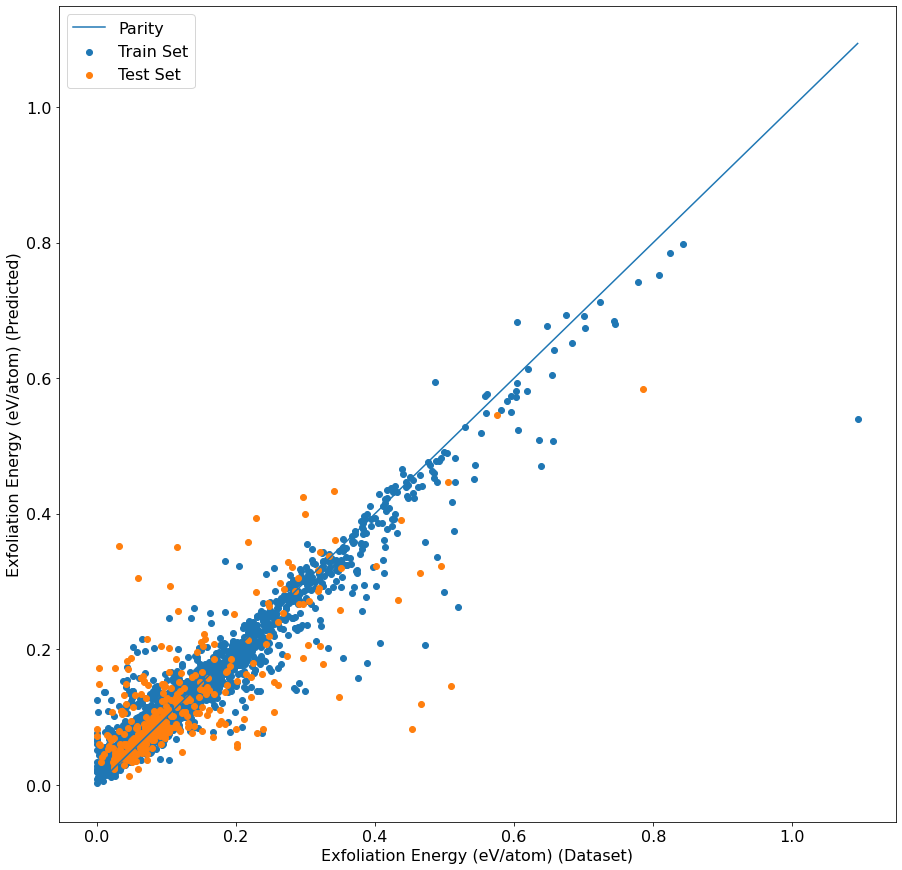

In [89]:
# def save_parity_plot(train_x, test_x, train_y, test_y, regression_model, label, filename):
#     train_pred_y = regression_model.predict(train_x)
#     test_pred_y = regression_model.predict(test_x)

#     plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
#     plt.rcParams["figure.figsize"] = (15, 15)
#     plt.rcParams["font.size"] = 16

#     plt.scatter(x=train_y, y=train_pred_y, label="Train Set")
#     plt.scatter(x=test_y, y=test_pred_y, label="Test Set")

#     min_xy = min(min(train_y), min(test_y), min(test_pred_y), min(train_pred_y))
#     max_xy = max(max(train_y), max(test_y), max(test_pred_y), max(train_pred_y))

#     min_xy = 0
#     max_xy = 1

#     plt.xlim([0,1])
#     plt.ylim([0,1])

#     plt.plot([min_xy, max_xy], [min_xy, max_xy], label="Parity")
#     plt.ylabel(f"{label} (Predicted)")
#     plt.xlabel(f"{label} (Dataset)")
#     plt.legend()
#     plt.savefig(filename)
#     plt.show()
#     plt.close()

DigitalEcosystem.utils.figures.save_parity_plot(train_x_reg,
                                                test_x_reg,
                                                train_y_reg,
                                                test_y_reg,
                                                best_reg,
                                                "Exfoliation Energy (eV/atom)",
                                                "parity.jpeg")

In [90]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

y_pred_test = best_reg.predict(test_x_reg)
for key, fun in metrics.items():
    value = fun(y_true=test_y_reg, y_pred=y_pred_test)
    print(key,np.round(value,3))

MaxError 0.371
MAE 0.042
MSE 0.005
RMSE 0.069
MAPE 3.354
R2 0.57


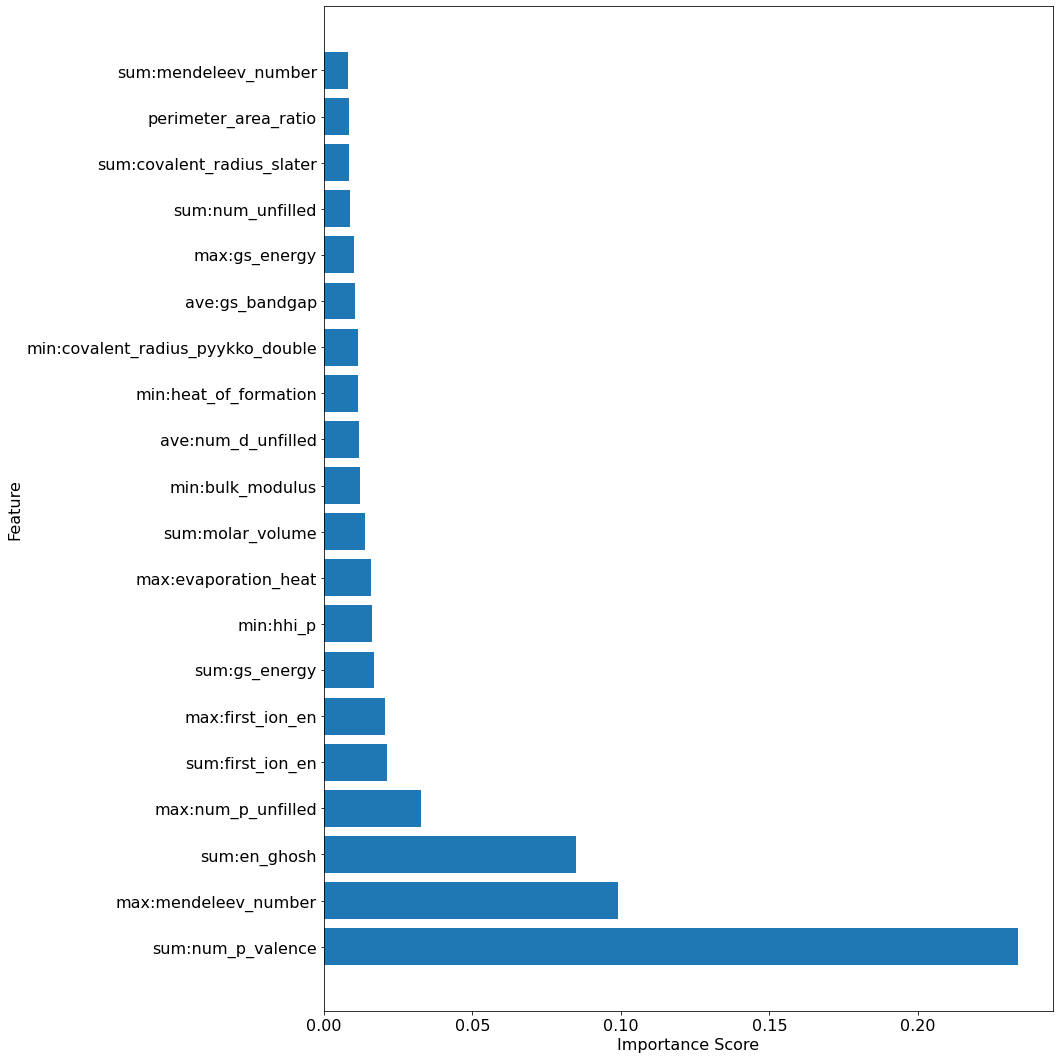

In [91]:
n_importances = 20
importances = list(zip(best_reg[1].feature_importances_, xenonpy_matminer_descriptors))

sorted_importances = list(sorted(importances, key=lambda i: -i[0]))



plt.barh(range(n_importances), [imp[0] for imp in sorted_importances[:n_importances]])
plt.yticks(range(n_importances), [imp[1] for imp in sorted_importances[:n_importances]])
plt.ylabel("Feature")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("Importances.jpeg")

<AxesSubplot:xlabel='exfoliation_energy_per_atom (eV/atom)', ylabel='Count'>

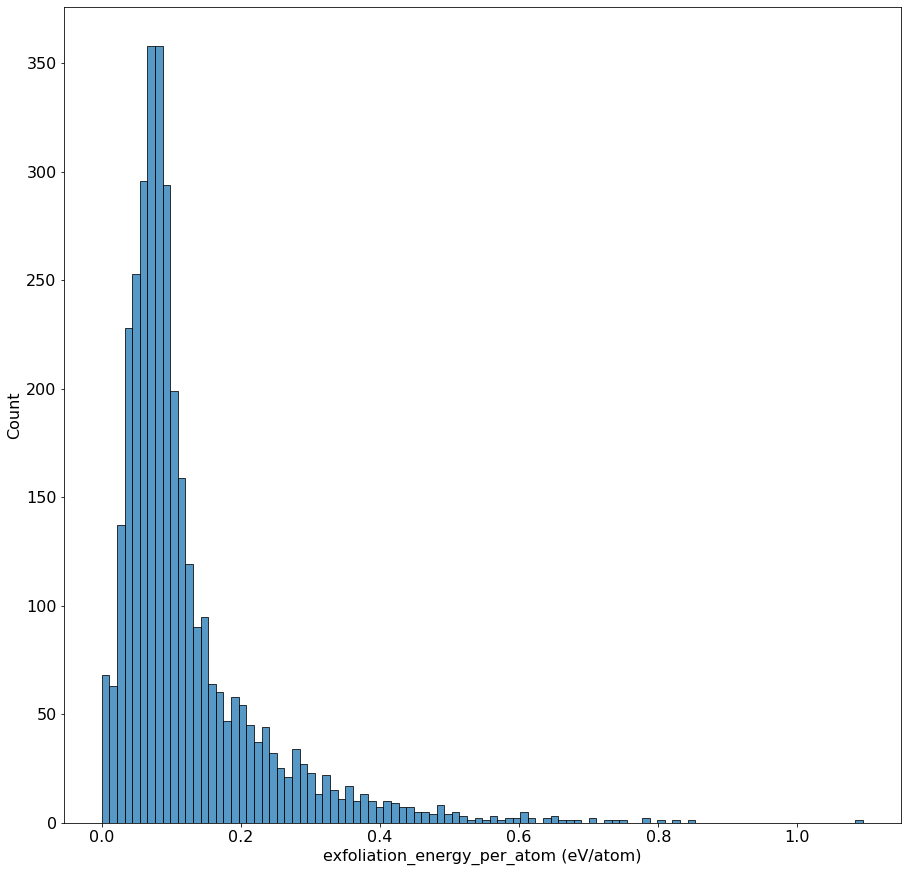

In [93]:
sns.histplot(reasonable['exfoliation_energy_per_atom (eV/atom)'])